In [2]:
import numpy as np
import pandas as pd
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as mticker
import sys, os
from hsbmpy import plot_topic_size, get_max_available_L
from hypergeom import parameters_for_hypergeometric, build_map, plot_map

In [77]:
directory="/home/jovyan/work/phd/datasets/paper/gtex10seed"
os.chdir(directory)
sys.path.append('/home/jovyan/work/phd/')

In [78]:
L = get_max_available_L(directory)

In [79]:
df = pd.read_csv("mainTable.csv", index_col=[0])

# topic size

In [ ]:
for l in range(0,L+1):
    plot_topic_size(directory,l)

## Topic O

In [ ]:
df = pd.read_csv("mainTable.csv", index_col=0,header=0)

In [ ]:
df_mv=pd.DataFrame(data=[df.mean(1), df.var(1),df.apply(lambda x: len([x[x>0]])/float(len(x)), 1)], index=['average', 'var', 'O']).transpose()
df_mv.head()

In [ ]:
for l in range(0,L+1):
    fig = plt.figure(figsize=(15,8))
    ax = fig.subplots(1,2)
    candles = get_candles(directory,l,df_mv,ax[0])
    candlestick2_ohlc(ax[0], candles['open'],candles['high'],candles['low'],candles['close'],width=0.6,colordown='b')
    ax[1].hist((np.array(candles['open'])+np.array(candles['close']))/2, weights=candles['size'], range=(-0.05,1.05), bins=10, histtype='step')
    ax[1].set_xlabel("$O_i", fontsize=18)
    plt.show()
    fig.savefig("%s/topic_Ocandles_level_%d.pdf"%(directory,l))

# Geneontology

In [ ]:
from geneontology import get_ontology_df, ensg_to_symbol
from tableanalyser import get_symbol
import gseapy as gs

In [ ]:
import importlib, geneontology,tableanalyser
importlib.reload(geneontology)
importlib.reload(tableanalyser)
from geneontology import get_ontology_df, ensg_to_symbol
from tableanalyser import get_symbol

In [ ]:
l=L-1
algorithm = "topsbm"
df_topics = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_topics.csv")
df_topics_smooth = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_word-dist.csv",index_col=0)
df_topics_smooth.index = [g[:15] for g in df_topics_smooth.index]

In [ ]:
def get_topic_over_thr(topic_name, q=0.75):
    topic = df_topics_smooth[topic_name]
    topic = topic[topic>0]
    topic = topic[topic>topic.quantile(q=q)]
    return topic.sort_values(ascending=False)

In [ ]:
df_symbols= pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_pub_ensembl_id&col=md_ensembl_id&col=md_eg_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", index_col=[0], sep='\t')

In [ ]:
def get_sea():
    for g in df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]:
        yield get_symbol(g)

In [ ]:
with open("gback.txt",'w') as f:
    list(map(lambda x: f.writelines(x+'\n')if len(x)>1 else None, get_sea()))
    
with open("gback_ensg.txt",'w') as f:
    list(map(lambda x: f.writelines(x[:15]+'\n')if len(x)>1 else None, df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]))

In [ ]:
gs.get_library_name()

In [ ]:
#https://www.gsea-msigdb.org/gsea/downloads.jsp
gene_sets = ['GO_Molecular_Function_2018',
             'GO_Biological_Process_2018',
             'GO_Cellular_Component_2018',
             'Human_Phenotype_Ontology',
             'WikiPathways_2019_Human',
             '/home/jovyan/work/phd/MSigDB/c1.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c2.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c3.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c4.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c5.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c6.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c7.all.v7.1.symbols.gmt',
            ]

In [ ]:
threshhold = 5e-1
cutoff = 5e-1
background = len([g for g in get_sea()])
os.system("mkdir -p gsea")
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1), index_col=[0])
        print(topic)
    except:
        try:
            #gene_list = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
            gene_list = ensg_to_symbol(get_topic_over_thr(topic).index)
            print(topic)
            enriched_topic = get_ontology_df(gene_list, cutoff=cutoff, threshhold = threshhold, gene_sets = gene_sets, background=background)
            enriched_topic = enriched_topic.sort_values(by=['Adjusted P-value'], ascending=True)[:20]
            enriched_topic.to_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1))
        except:
            print(*sys.exc_info())
            continue
    print(enriched_topic)

In [ ]:
topic_pvalues = []
topic_gos = []
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("%s/gsea/gsea_level_%d_topic_%d.csv"%(directory,l,itopic+1))
        if len(enriched_topic.index) >0:
            p_val = np.sort(enriched_topic['Adjusted P-value'])[0]
            topic_pvalues.append(-np.log10(p_val))
            for goc in enriched_topic['Gene_set'][:10].unique():
                topic_gos.append(goc)
        print(topic)
    except:
        print("error", sys.exc_info()[0])

In [ ]:
fig = plt.figure()
x = np.arange(1,1+len(topic_pvalues))
c, _, _ = plt.hist(topic_pvalues, histtype='step', lw=2)
plt.plot([-np.log10(0.05) for _ in np.linspace(1,10,num=10)],np.arange(0,np.max(c)+5,(np.max(c)+5)/10), ls='--', lw=5, label="$\\alpha=0.05$")
plt.xlabel('-log(P-value)', fontsize=16)
plt.ylabel("number of topics")
#plt.ylim(0,0.055)
#plt.yscale('log')
plt.legend(fontsize=16)
fig.savefig("%s/pvaluescrosstopic(%d).png"%(directory,l))

In [ ]:
fig = plt.figure(figsize=(20,10))
gos, goscounts = np.unique(topic_gos,return_counts=True)
plt.barh(["\n".join(wrap(str(l).replace('_',' '),20)) for l in gos], goscounts)
plt.yticks(fontsize=15)
plt.show()
fig.savefig("%s/pvaluecategories(%d).pdf"%(directory,l))

# hypergeometric operlaps

In [80]:
from scipy.stats import hypergeom
from sklearn.metrics import v_measure_score
import seaborn as sns
sns.set_context('paper')

In [113]:
hsbm_list_topics = pd.read_csv("topsbm/topsbm_level_3_topics.csv")
gene_list = hsbm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
hsbm_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in hsbm_list_topics.columns:
    hsbm_list[[g[:15] for g in hsbm_list_topics[topic].dropna()]]=topic

In [112]:
hsbm_list_topics = pd.read_csv("topsbm-log/topsbm-log_level_3_topics.csv")
gene_list = hsbm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
hsbm_log_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in hsbm_list_topics.columns:
    hsbm_log_list[[g[:15] for g in hsbm_list_topics[topic].dropna()]]=topic

FileNotFoundError: [Errno 2] File topsbm-log/topsbm-log_level_3_topics.csv does not exist: 'topsbm-log/topsbm-log_level_3_topics.csv'

In [ ]:
wgcna_list = pd.read_csv("wgcna/wgcna_level_0_word-dist.csv", index_col=0).apply(pd.Series.idxmax,axis=1)
wgcna_list.index = [g[:15] for g in wgcna_list.index]

In [82]:
tm_list = pd.read_csv("tm/tm_level_0_word-dist.csv", index_col=0).apply(pd.Series.idxmax,axis=1)

In [114]:
lda_list_topics = pd.read_csv("lda/lda_level_1_topics.csv")
gene_list = lda_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
lda_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in lda_list_topics.columns:
    lda_list[lda_list.index.isin([g[:15] for g in lda_list_topics[topic].dropna()])]=topic
lda_list=lda_list.reset_index().drop_duplicates("index").set_index("index")
lda_list=pd.Series(index=lda_list.index, data=lda_list.values.ravel())

In [115]:
list_1 = hsbm_list
list_2 = lda_list

first_name = "hsbm"
last_name = "lda"

#to uniform
list_1 = list_1[list_1.index.isin(list_2.index)]
list_2 = list_2[list_2.index.isin(list_1.index)]

In [116]:
hyper_params = parameters_for_hypergeometric(list_1, list_2)
df_cmap = build_map(*hyper_params)

(5, 14)


In [117]:
df_cmap[df_cmap<2]=0
df_cmap = df_cmap.sort_values(by=[t for t in df_cmap.columns], ascending=False)

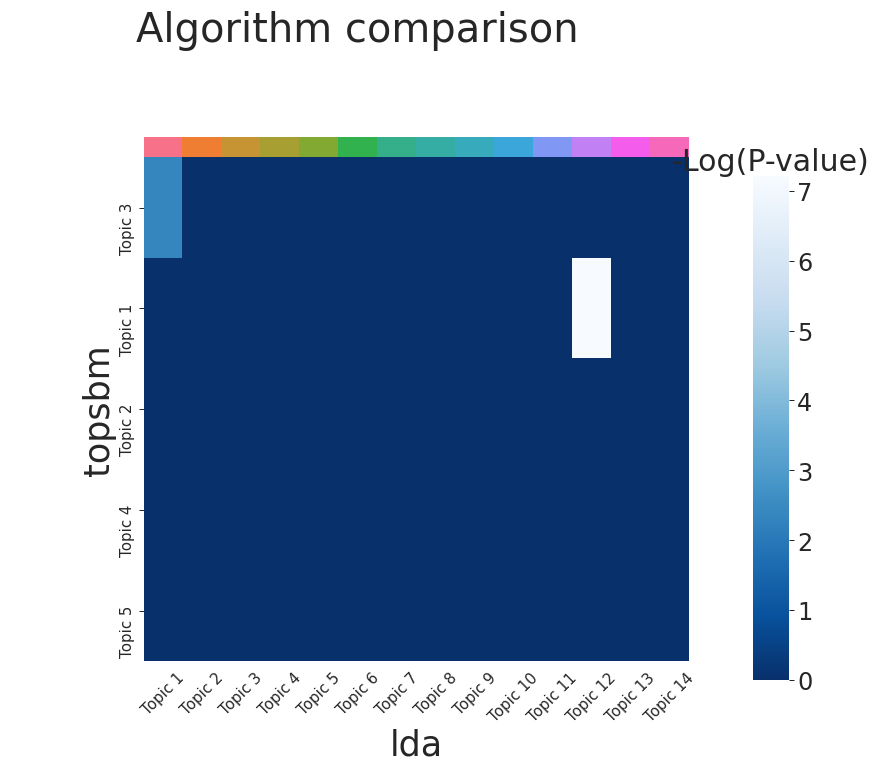

In [118]:
plot_map(df_cmap)

In [119]:
print("hsbm - lda %.3f"%v_measure_score(list_1, list_2))

hsbm - lda 0.048


In [ ]:
list(map(print,list_1[list_1=="Topic 39"].index))

In [ ]:
print("hsbm - wgcna %.3f"%v_measure_score(hsbm_list, wgcna_list))
print("hsbm - tm %.3f"%v_measure_score(hsbm_list.reindex_like(tm_list), tm_list))
print("tm - wgcna %.3f"%v_measure_score(tm_list, wgcna_list.reindex_like(tm_list)))
print("hsbm - lda %.3f"%v_measure_score(hsbm_list, lda_list.reindex_like(hsbm_list)))

In [122]:
for g in hsbm_list[hsbm_list=="Topic 1"].index:
    print(g)

ENSG00000160213
ENSG00000130203
ENSG00000131095
ENSG00000173432
ENSG00000121552
ENSG00000160180
ENSG00000161634
ENSG00000099194
ENSG00000239839
ENSG00000135916
ENSG00000167676
ENSG00000136717
ENSG00000197971
ENSG00000172005
ENSG00000154146
ENSG00000137077
ENSG00000124102
ENSG00000096696
ENSG00000129170
ENSG00000188404
ENSG00000086967
ENSG00000125780
ENSG00000171476
ENSG00000081277
ENSG00000163359
ENSG00000125144
ENSG00000176788
ENSG00000132639
ENSG00000166819
ENSG00000135218
ENSG00000137309
ENSG00000143753
ENSG00000136689
ENSG00000183091
ENSG00000175130
ENSG00000175445
ENSG00000118785
ENSG00000120053
ENSG00000167588
ENSG00000087250
ENSG00000159173
ENSG00000112303
ENSG00000064205
ENSG00000163563
ENSG00000154330
ENSG00000162747
ENSG00000133710
ENSG00000105374
ENSG00000139433
ENSG00000148346
ENSG00000186832
ENSG00000138207
ENSG00000215861
ENSG00000187116
ENSG00000115590
ENSG00000171346
ENSG00000163464
ENSG00000175315
ENSG00000183036
ENSG00000166831
ENSG00000196754
ENSG00000077157
ENSG0000